In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")

sns.set_style()

In [2]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')

In [3]:
paises = ['Mexico', 'Argentina', 'Ecuador', 'Chile', 'Spain']
df = dados[dados['Country/Region'].isin(paises)]

In [4]:
df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

## SARIMAX

In [5]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

##### Aplicando a tecnica de SARIMAX na coluna 'New cases'

In [6]:
novos_casos = df[['Date','New cases']].copy()
#novos_casos.set_index('Date', inplace=True)

In [7]:
%%time

# criando o modelo
auto_arima(novos_casos['New cases'],seasonal=True,m=7).summary()

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(novos_casos['New cases'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=17519.376, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17696.018, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17164.382, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17694.018, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17170.874, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17084.491, Time=0.77 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=16930.207, Time=2.13 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17068.265, Time=0.42 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=16740.685, Time=2.26 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=16932.776, Time=2.48 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=16661.226, Time=3.20 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=17297.347, Time=1.82 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=17025.094, Time=2.35 sec
 ARIMA(0,1,1)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -7812.491
Date:                                Sat, 03 Dec 2022   AIC                          15648.981
Time:                                        16:08:28   BIC                          15707.119
Sample:                                             0   HQIC                         15671.145
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.067     -0.978      0.328      -0.198       0.066
ar.L2         -0.2108      0.036     -5.889      0.000      -0.281      -0.141
ar.L3         -0.1325      0.048     -2.785      0.005      -0.226      -0.039
ar.L4         -0.1369      0.054     -2.536      0.011      -0.243      -0.031
ar.L5          0.5595      0.039     14.221      0.000       0.482       0.637
ar.L6         -0.0750      0.061     -1.221      0.222      -0.195       0.045
ma.L1         -0.9501      0.022    -44.086      0.000      -0.992      -0.908
ar.S.L7        0.6284      0.032     19.671      0.000       0.566       0.691
ar.S.L14      -0.9396      0.026    -36.649      0.000      -0.990      -0.889
ma.S.L7       -0.5477      0.054    -10.208      0.000      -0.653      -0.443
ma.S.L14       0.7981      0.049     16.450      0.000       0.703       0.893
sigma2       1.12e+06   2.35e+04     47.665      0.000    1.07e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             54439.23
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
%%time

cut = int(novos_casos.shape[0] * 0.80)
train = novos_casos.iloc[:cut]
test = novos_casos.iloc[cut:]

# modelo
model = SARIMAX(train['New cases'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()
model_fit.summary()

CPU times: total: 6.03 s
Wall time: 9.98 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              New cases   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6279.807
Date:                                Sat, 03 Dec 2022   AIC                          12583.614
Time:                                        16:08:41   BIC                          12639.071
Sample:                                             0   HQIC                         12604.981
                                                - 752                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0849      0.095     -0.898      0.369      -0.270       0.100
ar.L2         -0.2033      0.047     -4.306      0.000      -0.296      -0.111
ar.L3         -0.1543      0.047     -3.269      0.001      -0.247      -0.062
ar.L4         -0.1724      0.064     -2.704      0.007      -0.297      -0.047
ar.L5          0.5757      0.047     12.264      0.000       0.484       0.668
ar.L6         -0.1119      0.090     -1.236      0.216      -0.289       0.066
ma.L1         -0.9442      0.029    -33.082      0.000      -1.000      -0.888
ar.S.L7        0.3266      0.055      5.989      0.000       0.220       0.434
ar.S.L14      -0.8679      0.059    -14.602      0.000      -0.984      -0.751
ma.S.L7       -0.1783      0.054     -3.313      0.001      -0.284      -0.073
ma.S.L14       0.9087      0.050     18.074      0.000       0.810       1.007
sigma2      1.229e+06   3.54e+04     34.734      0.000    1.16e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             41168.61
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):            1554.76   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

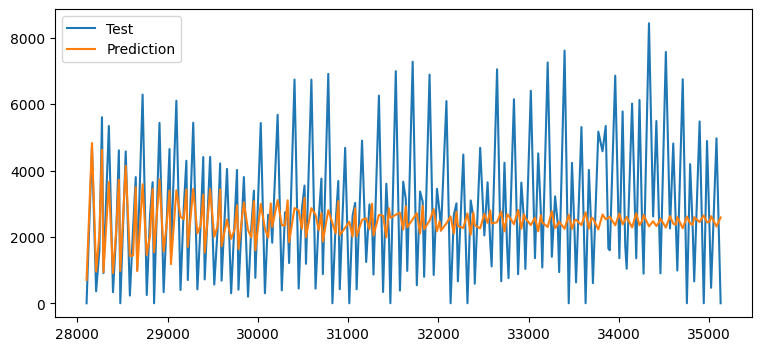

CPU times: total: 172 ms
Wall time: 356 ms


In [11]:
%%time

start = train.shape[0]
end   = novos_casos.shape[0] - 1

pred = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
pred.index = test.index

plt.figure(figsize=(14,10))
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

## Modelo

In [ ]:
y = pd.Series(query_paises_cem['New cases'].values, query_paises_cem['Date'].values)

In [ ]:
y_train, y_test = temporal_train_test_split(y)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [ ]:
covid = query_paises_cem[['New cases','New deaths']]

covid.plot(figsize=(9,4))
plt.show()

### Diferença entre os novos casos por dia

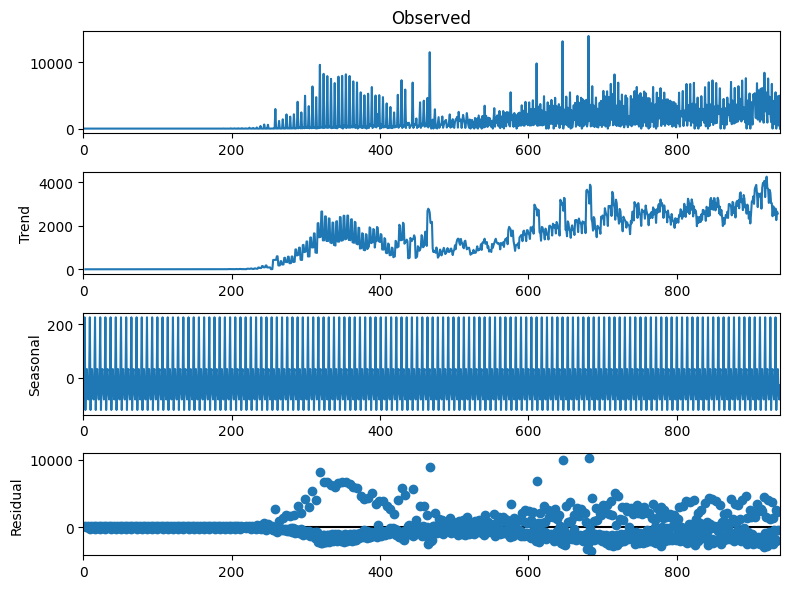

In [ ]:
novos_casos = np.array(y)

# decompor por semana
result = seasonal_decompose(novos_casos, model='additive', period=7)

fig = result.plot()
fig.set_size_inches((8, 6))

fig.tight_layout()
plt.show()

In [ ]:
#!pip install pmdarima

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# criando o modelo
auto_arima(covid['New cases'],seasonal=True,m=7).summary()

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(covid['New cases'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=17519.376, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17696.018, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17164.382, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17694.018, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17170.874, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17084.491, Time=1.18 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=16930.207, Time=3.37 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17068.265, Time=0.57 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=16740.685, Time=3.13 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=16932.776, Time=3.45 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=16661.226, Time=4.32 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=17297.347, Time=2.70 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=17025.094, Time=2.87 sec
 ARIMA(0,1,1)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -7812.491
Date:                                Fri, 02 Dec 2022   AIC                          15648.981
Time:                                        18:23:36   BIC                          15707.119
Sample:                                             0   HQIC                         15671.145
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.067     -0.978      0.328      -0.198       0.066
ar.L2         -0.2108      0.036     -5.889      0.000      -0.281      -0.141
ar.L3         -0.1325      0.048     -2.785      0.005      -0.226      -0.039
ar.L4         -0.1369      0.054     -2.536      0.011      -0.243      -0.031
ar.L5          0.5595      0.039     14.221      0.000       0.482       0.637
ar.L6         -0.0750      0.061     -1.221      0.222      -0.195       0.045
ma.L1         -0.9501      0.022    -44.086      0.000      -0.992      -0.908
ar.S.L7        0.6284      0.032     19.671      0.000       0.566       0.691
ar.S.L14      -0.9396      0.026    -36.649      0.000      -0.990      -0.889
ma.S.L7       -0.5477      0.054    -10.208      0.000      -0.653      -0.443
ma.S.L14       0.7981      0.049     16.450      0.000       0.703       0.893
sigma2       1.12e+06   2.35e+04     47.665      0.000    1.07e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             54439.23
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
cut = int(covid.shape[0] * 0.80)
train = covid.iloc[:cut]
test = covid.iloc[cut:]

# modelo
model = SARIMAX(train['New cases'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()
model_fit.summary()

C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brodr\AppData\Local\Packages\PythonSoftwar

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              New cases   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6279.807
Date:                                Fri, 02 Dec 2022   AIC                          12583.614
Time:                                        18:25:33   BIC                          12639.071
Sample:                                             0   HQIC                         12604.981
                                                - 752                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0849      0.095     -0.898      0.369      -0.270       0.100
ar.L2         -0.2033      0.047     -4.306      0.000      -0.296      -0.111
ar.L3         -0.1543      0.047     -3.269      0.001      -0.247      -0.062
ar.L4         -0.1724      0.064     -2.704      0.007      -0.297      -0.047
ar.L5          0.5757      0.047     12.264      0.000       0.484       0.668
ar.L6         -0.1119      0.090     -1.236      0.216      -0.289       0.066
ma.L1         -0.9442      0.029    -33.082      0.000      -1.000      -0.888
ar.S.L7        0.3266      0.055      5.989      0.000       0.220       0.434
ar.S.L14      -0.8679      0.059    -14.602      0.000      -0.984      -0.751
ma.S.L7       -0.1783      0.054     -3.313      0.001      -0.284      -0.073
ma.S.L14       0.9087      0.050     18.074      0.000       0.810       1.007
sigma2      1.229e+06   3.54e+04     34.734      0.000    1.16e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             41168.61
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):            1554.76   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Decomposição da serie temporal

C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


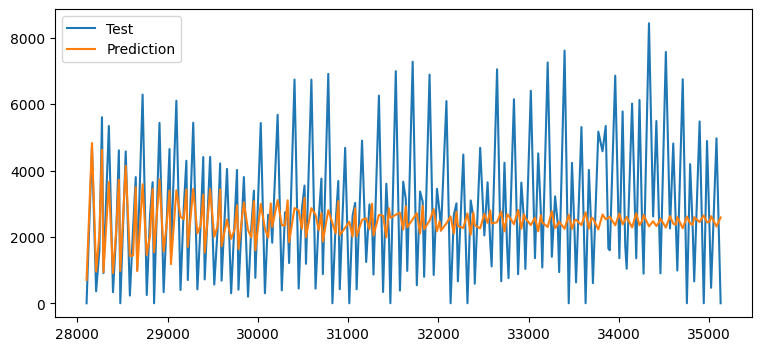

In [ ]:
start = train.shape[0]
end   = covid.shape[0] - 1

pred = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
pred.index = test.index

plt.figure(figsize=(14,10))
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

Comparando a serie verdadeira com a serie predita

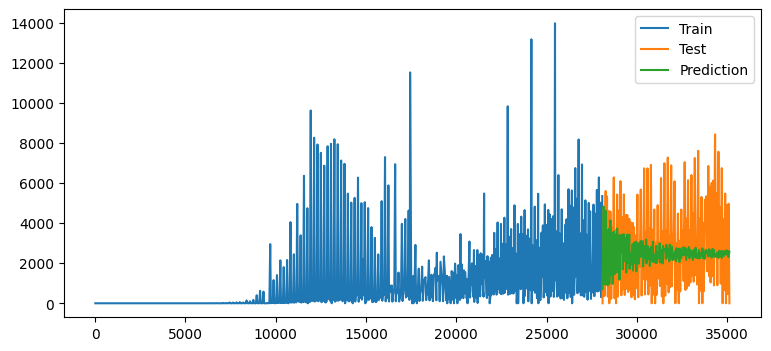

In [ ]:
plt.figure(figsize=(14,10))
train['New cases'].plot(legend=True, label='Train')
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()